## This code implements the necessary functionalities for selecting & combining multiple dose grids.

In [1]:
import pydicom
import numpy as np
import os
import SimpleITK as sitk

### Function to Load DICOM Files:

•	Purpose: This function scans the specified directory and reads each DICOM file, organizing them by their modality (CT, RTDOSE, RTPLAN, RTSTRUCT). 

•	Dictionary Initialization: The dictionary dicoms is used to categorize the files based on the Modality attribute, which is standard across DICOM files. It initializes a dictionary with keys corresponding to the different DICOM modalities we expect to handle: CT, RTDOSE, RTPLAN, and RTSTRUCT. Each key maps to an empty list intended to store DICOM files of that modality.

•	Specific Handling for RTDOSE: While all modalities are processed uniformly by storing the files in the appropriate lists, additional processing is done for RTDOSE files. If the file has a pixel_array attribute (which contains the dose data), the function prints the maximum value found in this array. This step is particularly useful for quickly assessing the dose values directly from the DICOM files without needing further processing steps.

•	Error Handling: Includes a try-except block to catch and report errors that occur during the reading of DICOM files. This could be due to corrupt files, incorrect file formats, or other issues preventing a file from being read as a DICOM file.

In [2]:
import os
import pydicom
import numpy as np
import SimpleITK as sitk

def load_dicom_files(folder_path):
    # Dictionary to hold lists of DICOM files by their modality
    dicoms = {'CT': [], 'RTDOSE': [], 'RTPLAN': [], 'RTSTRUCT': []}

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            path = os.path.join(root, file)
            try:
                dicom = pydicom.dcmread(path)
                # Check the modality of each DICOM file and process accordingly
                if dicom.Modality in dicoms:
                    # Add the DICOM file to the appropriate list based on its Modality
                    dicoms[dicom.Modality].append(dicom)
                    # Print specific information for RTDOSE files
                    if dicom.Modality == 'RTDOSE':
                        # Use SimpleITK to read the dose grid
                        dose = sitk.ReadImage(path)
                        # Convert the dose grid to float 
                        dose = sitk.Cast(dose, sitk.sitkFloat32)
                        # Apply the DoseGridScaling from the DICOM file
                        if hasattr(dicom, 'DoseGridScaling'):
                            dose_array = sitk.GetArrayFromImage(dose) * float(dicom.DoseGridScaling)
                            print(f"Loaded Dose Grid for {file}: Max Value - {np.max(dose_array)}")
                        else:
                            print(f"DoseGridScaling attribute missing in {file}")
            except Exception as e:
                print(f"Failed to read {path}: {str(e)}")

    # After all files have been processed, return the dictionary
    return dicoms


### Function to Verify Linkages

Purpose: This function checks and verifies the relationships between RTPLAN and RTSTRUCT, and then RTDOSE and RTPLAN based on UIDs to ensure that each RTDOSE is linked to the correct plan and structure set. It also checks the uniqueness of RTPLAN and RTDOSE individually before allowing the individual dose grids to be added. We have divided this function in separate components.

Implementation: RTPLAN Processing:

•	Uniqueness check of RTPLAN using composite key: It uses a combination of PlanName, NumberOfFractionsPlanned, and TreatmentMachineName to create a unique identifier for each RTPLAN. It uses a set to track which composite keys have been seen, ensuring each plan is processed only if it’s unique. 

•	Linking with RTSTRUCT: If the RTPLAN is either unique or a duplicate but still needs processing for linking, the function checks if it has a ReferencedStructureSetSequence linking it to an RTSTRUCT. This link (corresponding plain_uid) is then stored in the stored_plans dictionary, mapping RTPLAN UIDs to RTSTRUCT UIDs, allowing for future reference when processing RTDOSE files.

RTDOSE Processing:

•	Uniqueness Check: Each RTDOSE file is checked for a pixel_array, ensuring it's a valid dose file and then is checked for uniqueness based on its dose grid. The function compares the current dose grid with previously stored dose grids in existing_dose_grids. If an identical grid is found, the RTDOSE is flagged as not unique; otherwise, it's added to the list of stored grids.

•	Visualization of Differences: For each comparison, whether the grid is unique or not, the differences between dose grids are visualized. This helps in visually confirming the results of the comparison.

•	Linkage Check: If the RTDOSE grid is unique, the function then checks if this RTDOSE has a ReferencedRTPlanSequence. If it does, the function verifies that the referenced RTPLAN UID is stored in stored_plans. This confirms that the RTDOSE is correctly linked to an RTPLAN (and indirectly to an RTSTRUCT, assuming the RTPLAN-RTSTRUCT link was correctly established).

Final Validation:

•	If all checks are passed (unique dose grid and correct linkage to RTPLAN and RTSTRUCT), the RTDOSE is considered valid and added to valid_doses. This dictionary collects all RTDOSE files that are correctly linked and unique, ready for further processing or analysis.

In [3]:
def verify_links(dicoms):
    plans_to_structs = {}
    existing_composite_keys = set() # Tracks composite keys to identify duplicate RTPLANs.
    stored_plans = {}  # Dictionary to store all plans regardless of composite key uniqueness
    valid_doses = {}  # Initialize the dictionary to store validated RTDOSE files
    existing_dose_grids = []  # List to store dose grids for comparison

    # Handle RTPLAN for composite key uniqueness and link to RTSTRUCT
    for plan in dicoms['RTPLAN']:
        composite_key = (
            plan.PlanName if 'PlanName' in plan else "Unnamed",
            plan.FractionGroupSequence[0].NumberOfFractionsPlanned if 'FractionGroupSequence' in plan else "Undefined",
            plan.TreatmentMachineName if 'TreatmentMachineName' in plan else "No Machine"
        )
        plan_uid = str(plan.SOPInstanceUID)
        if composite_key not in existing_composite_keys:
            existing_composite_keys.add(composite_key)
            print(f"Processing unique RTPLAN UID: {plan_uid}, Composite Key: {composite_key}")
        else:
            print(f"Duplicate RTPLAN based on composite key: {plan_uid}, Composite Key: {composite_key}")

        # Store all RTPLAN UIDs for potential RTDOSE linkage
        if 'ReferencedStructureSetSequence' in plan:
             # Convert UIDs to strings and check RTPLAN to RTSTRUCT linkage
            struct_uid = str(plan.ReferencedStructureSetSequence[0].ReferencedSOPInstanceUID)
            stored_plans[plan_uid] = struct_uid
            print(f"Linking RTPLAN {plan_uid} to RTSTRUCT {struct_uid}")

   # Process RTDOSE files for uniqueness and check linkage to RTPLAN
    for dose in dicoms['RTDOSE']:
        if hasattr(dose, 'pixel_array'):
            dose_uid = str(dose.SOPInstanceUID)
            unique = True  # Flag to track uniqueness

            # Compare with existing dose grids
            for existing_grid in existing_dose_grids:
                if np.array_equal(dose.pixel_array, existing_grid):
                    print(f"Duplicate dose grid found for RTDOSE {dose_uid}.")
                    unique = False
                    break

            if unique:
                existing_dose_grids.append(dose.pixel_array)

                if 'ReferencedRTPlanSequence' in dose:
                    # Convert UIDs to strings and check RTDOSE to RTPLAN linkage
                    ref_plan_uid = str(dose.ReferencedRTPlanSequence[0].ReferencedSOPInstanceUID)
                    if ref_plan_uid in stored_plans and any(str(struct.SOPInstanceUID) == stored_plans[ref_plan_uid] for struct in dicoms['RTSTRUCT']):
                        valid_doses[dose_uid] = dose
                        print(f"RTDOSE {dose_uid} is unique and correctly linked to RTPLAN and RTSTRUCT.")
                    else:
                        print(f"RTDOSE {dose_uid} does not link correctly to any RTSTRUCT or RTPLAN.")
                else:
                    print(f"RTDOSE {dose_uid} does not have ReferencedRTPlanSequence.")
            else:
                print(f"RTDOSE {dose_uid} is not unique based on dose grid.")

    return valid_doses

### Function to Sum Doses

Purpose: Sums up all the dose grids from the validated RTDOSE files.

Implementation: It initializes a dose grid with zeros and then iteratively adds up all valid dose grids.

In [4]:
import SimpleITK as sitk
import numpy as np

def sum_doses(valid_doses):
    sum_dose = None  # Initialize the sum of doses as None

    for dose_uid, dose_dicom in valid_doses.items():
        try:
            # Convert pixel_array to SimpleITK Image for processing
            dose_image = sitk.GetImageFromArray(dose_dicom.pixel_array.astype(np.float32))
            # Check and apply the DoseGridScaling factor
            if hasattr(dose_dicom, 'DoseGridScaling'):
                dose_image = sitk.Cast(dose_image, sitk.sitkFloat32)
                scaled_dose = dose_image * float(dose_dicom.DoseGridScaling)
            else:
                print(f"DoseGridScaling attribute missing in {dose_uid}, using unmodified dose")
                scaled_dose = dose_image

            # Sum the doses
            if sum_dose is None:
                sum_dose = scaled_dose  # If sum_dose is None, initialize it with the first dose
            else:
                sum_dose += scaled_dose  # Add the current dose to the sum of previous doses

        except Exception as e:
            print(f"Failed to process dose {dose_uid}: {str(e)}")

    if sum_dose is not None:
        # Convert the summed dose back to a numpy array for compatibility with existing code or further processing
        summed_dose_array = sitk.GetArrayFromImage(sum_dose)
        print("Summed Dose Grid:\n", summed_dose_array)
        return summed_dose_array

    return None

### Function to Compare with a Max Dose

This function checks the maximum value in the summed dose grid against a specified threshold (max_threshold). If the maximum dose exceeds this limit, it prints a warning and returns False, indicating the validation failed.

In [5]:
def validate_dose(summed_dose, max_threshold):
    max_dose = np.max(summed_dose)
    print(f"Maximum dose in the summed dose grid: {max_dose}")
    if max_dose > max_threshold:
        print("Warning: Dose exceeds the maximum threshold.")
        return False
    else:
        print("Dose is within the safe limits.")
        return True

### Create A New RTDOSE DICOM

1. Create a New DICOM Dataset

2. Populate Standard DICOM Tags by copying the necessary tags from a reference dicom file. 

3. Assigning new identifiers like SOPInstanceUID and SeriesInstanceUID to ensure that the new file is uniquely identifiable within a DICOM system, along with important metadata and image-specific attributes like BitsAllocated, BitsStored, HighBit, and PixelRepresentation to define how pixel data (in this case, dose data) is encoded in the DICOM file.

4. Inserting the summed dose grid with pixel data attribute, specifically using the summed_dose.tobytes() method to convert into a byte string appropriate for DICOM file storage.

5. Creating and saving the new DICOM file.

In [6]:
import pydicom
from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.uid import ExplicitVRLittleEndian, PYDICOM_IMPLEMENTATION_UID, RTDoseStorage

def create_rt_dose_dicom(summed_dose, reference_dicom):
    # Create a new DICOM dataset
    new_rt_dose = Dataset()

    # Copy relevant tags from the reference RTDOSE DICOM file
    tags_to_copy = ['PatientID', 'StudyInstanceUID', 'SeriesInstanceUID', 'FrameOfReferenceUID', 'StudyID', 'PatientName']
    for tag in tags_to_copy:
        if hasattr(reference_dicom, tag):
            setattr(new_rt_dose, tag, getattr(reference_dicom, tag))

    # Mandatory DICOM attributes for RTDOSE
    new_rt_dose.Modality = 'RTDOSE'
    new_rt_dose.Manufacturer = 'Your Manufacturer'  # Adjust as appropriate
    new_rt_dose.DoseSummationType = 'PLAN'  # Adjust based on how doses are summed
    new_rt_dose.SOPClassUID = RTDoseStorage
    new_rt_dose.SOPInstanceUID = pydicom.uid.generate_uid()
    new_rt_dose.StudyDate = reference_dicom.StudyDate if 'StudyDate' in reference_dicom else ''
    new_rt_dose.SeriesInstanceUID = pydicom.uid.generate_uid()  # Optionally, generate a new series UID

    # Image specific attributes
    new_rt_dose.BitsAllocated = 16  # Commonly set to 16 for RTDOSE
    new_rt_dose.BitsStored = 16
    new_rt_dose.HighBit = 15
    new_rt_dose.PixelRepresentation = 1  # 0 for unsigned, 1 for signed

    # Setting the dose grid data
    new_rt_dose.Rows, new_rt_dose.Columns = summed_dose.shape[1], summed_dose.shape[2]
    new_rt_dose.NumberOfFrames = summed_dose.shape[0]
    new_rt_dose.PixelData = summed_dose.tobytes()

    # File meta information, required for DICOM files
    file_meta = FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = new_rt_dose.SOPClassUID
    file_meta.MediaStorageSOPInstanceUID = new_rt_dose.SOPInstanceUID
    file_meta.ImplementationClassUID = PYDICOM_IMPLEMENTATION_UID
    file_meta.TransferSyntaxUID = ExplicitVRLittleEndian  # Assuming the use of Explicit VR Little Endian

    # Combine the dataset and the file meta into a new DICOM file
    new_rt_dose.file_meta = file_meta
    new_rt_dose.is_little_endian = True
    new_rt_dose.is_implicit_VR = False

    # Save the new DICOM file
    new_rt_dose.save_as('new_summed_rt_dose.dcm')

# This function now properly sets all necessary DICOM attributes.

In [7]:
import matplotlib.pyplot as plt
 
def visualize_dose_grid(dose_grid):
    # Assuming dose_grid is a 3D numpy array
    # Visualize the middle slice of the grid along the z-axis
    mid_slice = dose_grid.shape[2] // 2
    plt.imshow(dose_grid[:, :, mid_slice], cmap='hot')
    plt.colorbar()
    plt.title("Dose Distribution on Middle Slice")
    plt.show()

### Main Function

Execution Flow: This is where the functions are called in sequence to load DICOM files, validate their linkages, sum the doses, and then output the results.

1.	Loading all DICOM files.

2.	Verify linkage between RTDOSE, RTPLAN and RTSTRUCT and further confirms the uniqueness of the RTPLAN and RTDOSE. If all passed, then valid doses are obtained and summed accordingly by again comparing the summed dose against a maximum threshold.

3.	Passing the reference DICOM (typically the first available RTDOSE file) and summed dose grid for creating a new RTDOSE DICOM. 

Loaded Dose Grid for RD.Physics_JS.zD4 OpBH.dcm: Max Value - 28.842092514038086
Loaded Dose Grid for RD.Physics_JS.zD4 ImBH.dcm: Max Value - 23.033327102661133
Loaded Dose Grid for RD.Physics_JS.zD4 SCF.dcm: Max Value - 43.64101028442383


/Users/60228808/dev/pydicer/.venv/lib/python3.8/site-packages/pydicom/dataset.py:594: UserWarning: Invalid value 'PlanName' used with the 'in' operator: must be an element tag as a 2-tuple or int, or an element keyword
  warnings.warn(msg)


Processing unique RTPLAN UID: 1.2.246.352.71.5.76690441797.3107721.20240219144537, Composite Key: ('Unnamed', '15', 'No Machine')
Linking RTPLAN 1.2.246.352.71.5.76690441797.3107721.20240219144537 to RTSTRUCT 1.2.246.352.71.4.76690441797.620525.20240219151440
Duplicate RTPLAN based on composite key: 1.2.246.352.71.5.76690441797.3107708.20240219150747, Composite Key: ('Unnamed', '15', 'No Machine')
Linking RTPLAN 1.2.246.352.71.5.76690441797.3107708.20240219150747 to RTSTRUCT 1.2.246.352.71.4.76690441797.620525.20240219151440
Duplicate RTPLAN based on composite key: 1.2.246.352.71.5.76690441797.3107707.20240219150503, Composite Key: ('Unnamed', '15', 'No Machine')
Linking RTPLAN 1.2.246.352.71.5.76690441797.3107707.20240219150503 to RTSTRUCT 1.2.246.352.71.4.76690441797.620525.20240219151440
RTDOSE 1.2.246.352.71.7.76690441797.5185432.20240219151030 is unique and correctly linked to RTPLAN and RTSTRUCT.
RTDOSE 1.2.246.352.71.7.76690441797.5185427.20240219151059 is unique and correctly l

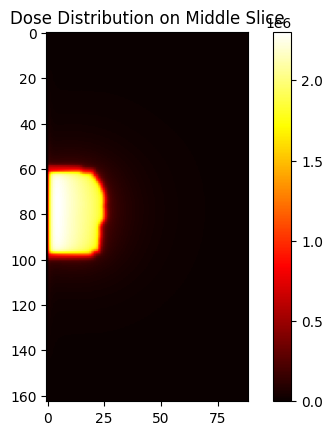

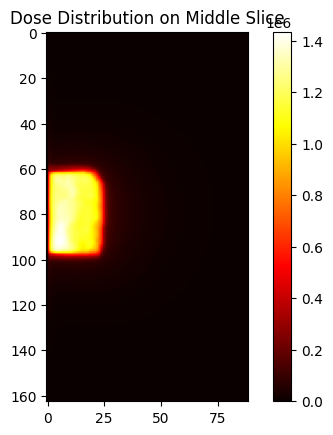

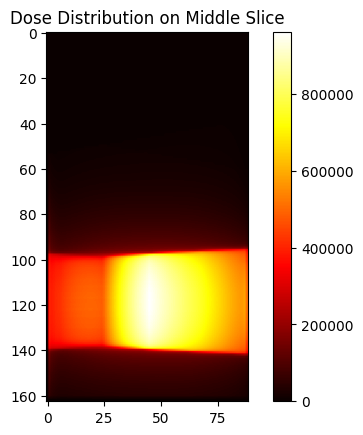

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


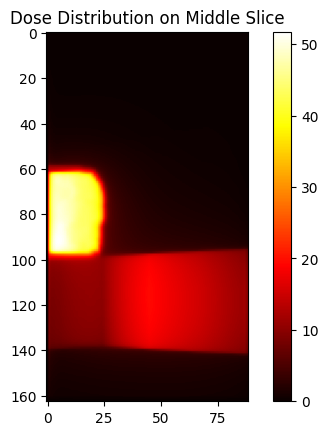

Maximum dose in the summed dose grid: 51.77133560180664
Dose is within the safe limits.
Dose validated and within limits.
New RTDOSE DICOM file has been created.


In [8]:
def main():
    folder_path = 'Physics_JS'
    max_dose_threshold = 150  # Define an appropriate threshold based on clinical needs
 
    # Load DICOM files
    dicoms = load_dicom_files(folder_path)
 
    # Verify links and get valid doses
    valid_doses = verify_links(dicoms)
 
    # Sum the valid doses
    if valid_doses:
        summed_dose = sum_doses(valid_doses)
 
        for dose in valid_doses.values():
            visualize_dose_grid(dose.pixel_array)
 
            # Visualize the summed dose grid
        print(summed_dose)
        if summed_dose is not None:
            visualize_dose_grid(summed_dose)
        else:
            print("Summed dose calculation failed or returned None.")
 
        # Validate the summed dose against the threshold
        if summed_dose is not None and validate_dose(summed_dose, max_dose_threshold):
            print("Dose validated and within limits.")
          
 
            # Reference DICOM file (for copying some metadata)
            reference_dicom = next(iter(valid_doses.values()))  # Use the first available RTDOSE file
 
            # Create and save new RTDOSE DICOM
            create_rt_dose_dicom(summed_dose, reference_dicom)
            #create_nifti(summed_dose)
            print("New RTDOSE DICOM file has been created.")
        else:
            print("Dose validation failed or dose exceeds the maximum threshold.")
    else:
        print("No valid doses found or all were duplicates.")
 
if __name__ == "__main__":
    main()

In [22]:
dose_path_1 = "./Physics_JS/RD.Physics_JS.zD4 ImBH.dcm"
dose_1 = sitk.ReadImage(str(dose_path_1))
dose_1 = sitk.Cast(dose_1, sitk.sitkFloat64)
dose_1 = dose_1 * (pydicom.read_file(dose_path_1)).DoseGridScaling

dose_path_2 = "./Physics_JS/RD.Physics_JS.zD4 OpBH.dcm"
dose_2 = sitk.ReadImage(str(dose_path_2))
dose_2 = sitk.Cast(dose_2, sitk.sitkFloat64)
dose_2 = dose_2 * (pydicom.read_file(dose_path_2)).DoseGridScaling

dose_path_3 = "./Physics_JS/RD.Physics_JS.zD4 SCF.dcm"
dose_3 = sitk.ReadImage(str(dose_path_3))
dose_3 = sitk.Cast(dose_3, sitk.sitkFloat64)
dose_3 = dose_3 * (pydicom.read_file(dose_path_3)).DoseGridScaling

summed_dose = dose_1 + dose_2 + dose_3
sitk.WriteImage(summed_dose, str("output.nii.gz"))

# visualize_dose_grid(sitk.GetArrayFromImage(summed_dose))

In [10]:
# from platipy.imaging.visualisation.dose import visualise_dose

# vis = ImageVisualiser("", cut=get_com(structures["PTV60"]))

# vis.add_scalar_overlay(dose, discrete_levels=20, colormap=matplotlib.colormaps.get_cmap("inferno"), name="Dose (Gy)")
# vis.add_contour(structures)

# fig = vis.show()